# Module 1 - Step 2: Exploratory Data Analysis & Feature Engineering

#### Bank Marketing Dataset

**Goal:** Predict if client subscribes to term deposit (yes/no)

**Size:** 41,188 records, 20 features | **Balance:** 11% yes, 89% no

*Source: Portuguese bank direct marketing campaigns (phone calls), May 2008 - Nov 2010*

---

## Workshop Learning Objectives

In this notebook, you will:
1. Perform comprehensive exploratory data analysis (EDA)
2. Understand the relationship between features and target variable
3. Quickly explore 2-3 baseline models
4. Extract and analyze feature importance
5. Engineer new features based on insights
6. Validate that new features improve model performance

In [1]:
import time
from datetime import datetime

# Start timer
notebook_start_time = time.time()
start_timestamp = datetime.now()

print("="*60)
print("NOTEBOOK EXECUTION STARTED")
print("="*60)
print(f"Start Time: {start_timestamp.strftime('%Y-%m-%d %H:%M:%S')}")
print("="*60)

NOTEBOOK EXECUTION STARTED
Start Time: 2025-10-30 14:34:02


## Setup: Import Libraries

In [1]:
# Core libraries
import sys
import os
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical tests
from scipy import stats

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, roc_auc_score, classification_report
)

# CML specific
import cml.data_v1 as cmldata

# Custom utilities
sys.path.append(os.path.dirname(os.getcwd()))
from shared_utils import (
    DATALAKE_CONFIG,
    get_spark_session
)

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✓ All imports successful!")

✓ All imports successful!


## 1. Load Data from Data Lake

In [2]:
# Configure connection to data lake
database_name = DATALAKE_CONFIG["database_name"] 
table_name = DATALAKE_CONFIG["table_name"]
username = os.environ["PROJECT_OWNER"]
CONNECTION_NAME = os.environ.get("CONNECTION_NAME", "se-aws-edl")

# Connect to Iceberg table
conn = cmldata.get_connection(CONNECTION_NAME)
spark = conn.get_spark_session()

# Build full table path
full_db = f"{database_name}_{username}".upper()
full_table = f"{table_name}_{username}".upper()
full_path = f"{full_db}.{full_table}"

print(f"Loading data from: {full_path}")
spark_df = spark.table(full_path)
df = spark_df.toPandas()

print(f"✓ Dataset loaded successfully!")
print(f"  Shape: {df.shape}")
print(f"  Rows: {df.shape[0]:,} | Columns: {df.shape[1]}")

Setting spark.hadoop.yarn.resourcemanager.principal to ozarate


Spark Application Id:spark-7f04d131ba364891bbf1f90b92610fe6
Loading data from: DEFAULT_OZARATE.BANK_MARKETING_OZARATE


Hive Session ID = b76c756c-f23e-4bc6-92ac-a84e5b8605c6


✓ Dataset loaded successfully!
  Shape: (41188, 21)
  Rows: 41,188 | Columns: 21


## 2. Initial Data Understanding

Let's get a quick overview of our dataset structure and quality.

In [3]:
# Display first few rows
print("First 5 rows of the dataset:")
display(df.head())

First 5 rows of the dataset:


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
# Check for missing values
print("\n" + "="*60)
print("MISSING VALUES ANALYSIS")
print("="*60)
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Percentage': missing_pct
})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

if len(missing_df) > 0:
    print(missing_df)
else:
    print("✓ No missing values detected!\n Typically we'll have missing values and have to address them.")


MISSING VALUES ANALYSIS
✓ No missing values detected!
 Typically we'll have missing values and have to address them.


In [5]:
# Target variable distribution
print("\n" + "="*60)
print("TARGET VARIABLE DISTRIBUTION")
print("="*60)
target_counts = df['y'].value_counts()
target_pct = df['y'].value_counts(normalize=True) * 100

print(f"\nSubscribed (yes): {target_counts['yes']:,} ({target_pct['yes']:.2f}%)")
print(f"Not Subscribed (no): {target_counts['no']:,} ({target_pct['no']:.2f}%)")
print(f"\nClass Imbalance Ratio: {target_counts['no'] / target_counts['yes']:.2f}:1")
print("\n⚠️  Note: This is an imbalanced dataset. We'll need to consider this in modeling.")



TARGET VARIABLE DISTRIBUTION

Subscribed (yes): 4,640 (11.27%)
Not Subscribed (no): 36,548 (88.73%)

Class Imbalance Ratio: 7.88:1

⚠️  Note: This is an imbalanced dataset. We'll need to consider this in modeling.


## 3. Univariate Analysis - Numerical Features

Let's examine the distribution of numerical features.

In [6]:
# Identify numerical columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove("duration") # duration is NOT a feature - only known at the time of sale/non sale
print(f"Numerical Features ({len(numeric_cols)}): {numeric_cols}")

# Descriptive statistics
print("\n" + "="*60)
print("DESCRIPTIVE STATISTICS FOR NUMERICAL FEATURES")
print("="*60)
display(df[numeric_cols].describe().T)

Numerical Features (9): ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

DESCRIPTIVE STATISTICS FOR NUMERICAL FEATURES


,count,mean,std,min,25%,50%,75%,max
age,41188.0,40.024060,10.421250,17.000,32.000,38.000,47.000,98.000
campaign,41188.0,2.567593,2.770014,1.000,1.000,2.000,3.000,56.000
pdays,41188.0,962.475454,186.910907,0.000,999.000,999.000,999.000,999.000
previous,41188.0,0.172963,0.494901,0.000,0.000,0.000,0.000,7.000
emp.var.rate,41188.0,0.081886,1.570960,-3.400,-1.800,1.100,1.400,1.400
cons.price.idx,41188.0,93.575664,0.578840,92.201,93.075,93.749,93.994,94.767
cons.conf.idx,41188.0,-40.502600,4.628198,-50.800,-42.700,-41.800,-36.400,-26.900
euribor3m,41188.0,3.621291,1.734447,0.634,1.344,4.857,4.961,5.045
nr.employed,41188.0,5167.035911,72.251528,4963.600,5099.100,5191.000,5228.100,5228.100


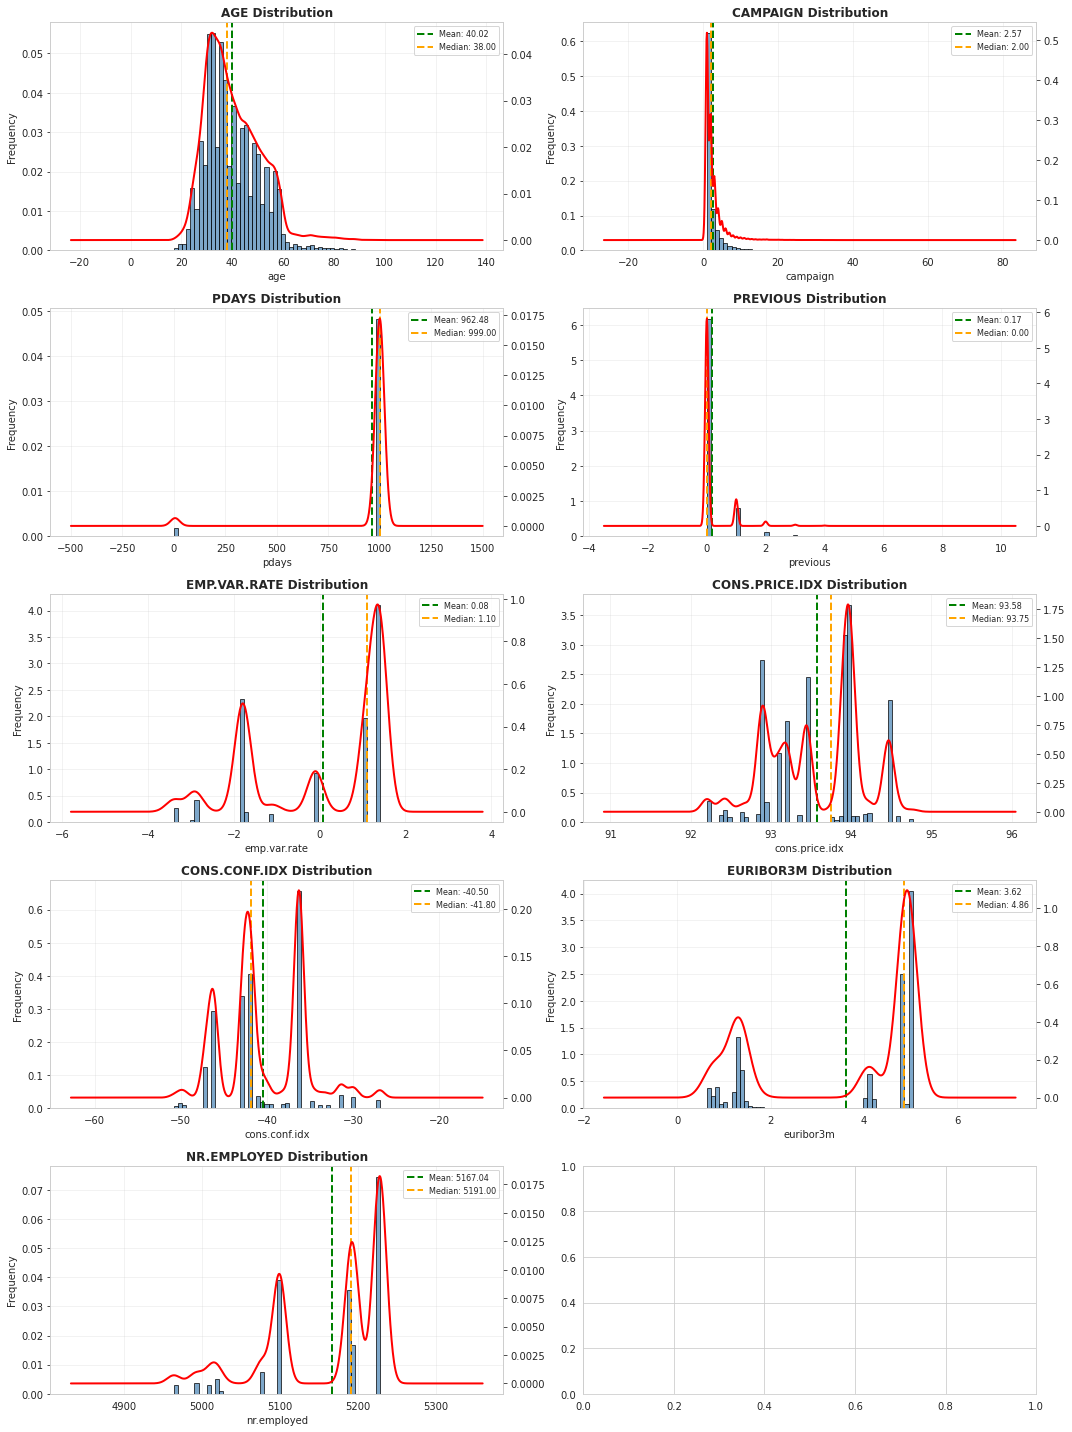


📊 KEY OBSERVATIONS:
  • 'pdays' has many 999 values (customer not previously contacted)
  • 'campaign' shows most customers contacted 1-3 times
  • Economic indicators show clustering around specific values


In [7]:
# Distribution plots for key numerical features
key_numeric = ['age', 'campaign', 'pdays', 'previous', 
               'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

# Filter to existing columns
key_numeric = [col for col in key_numeric if col in df.columns]

fig, axes = plt.subplots(5, 2, figsize=(15, 20))
axes = axes.ravel()

for idx, col in enumerate(key_numeric):
    if idx < len(axes):
        # Histogram with KDE
        axes[idx].hist(df[col].dropna(), bins=50, edgecolor='black', 
                      alpha=0.7, color='steelblue', density=True)
        
        # Add KDE line
        df[col].dropna().plot(kind='kde', ax=axes[idx], color='red', linewidth=2, secondary_y=True)
        
        axes[idx].set_title(f'{col.upper()} Distribution', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel(col, fontsize=10)
        axes[idx].set_ylabel('Frequency', fontsize=10)
        axes[idx].grid(alpha=0.3)
        
        # Add statistics text
        mean_val = df[col].mean()
        median_val = df[col].median()
        axes[idx].axvline(mean_val, color='green', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
        axes[idx].axvline(median_val, color='orange', linestyle='--', linewidth=2, label=f'Median: {median_val:.2f}')
        axes[idx].legend(fontsize=8)

plt.tight_layout()
plt.show()

print("\n📊 KEY OBSERVATIONS:")
print("  • 'pdays' has many 999 values (customer not previously contacted)")
print("  • 'campaign' shows most customers contacted 1-3 times")
print("  • Economic indicators show clustering around specific values")

## 4. Univariate Analysis - Categorical Features

Let's examine the distribution of categorical features.

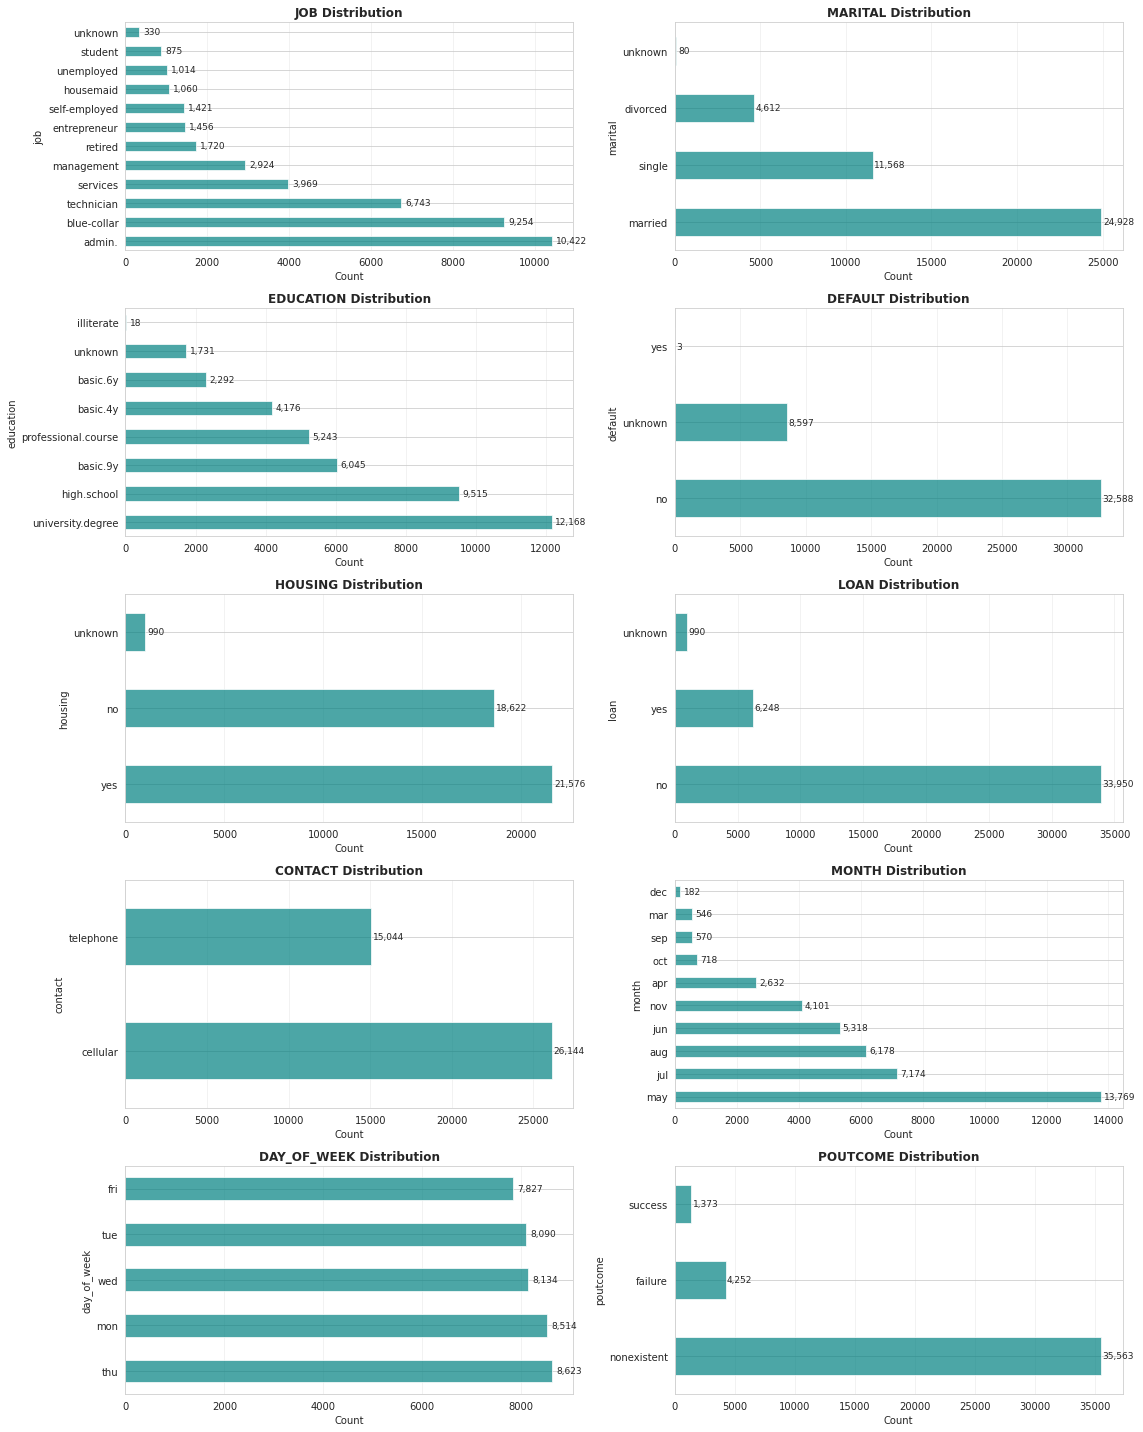

In [8]:
# Distribution of categorical features
cat_to_plot = ['job', 'marital', 'education', 'default', 'housing', 'loan', 
               'contact', 'month', 'day_of_week', 'poutcome']
cat_to_plot = [col for col in cat_to_plot if col in df.columns]

fig, axes = plt.subplots(5, 2, figsize=(16, 20))
axes = axes.ravel()

for idx, col in enumerate(cat_to_plot):
    if idx < len(axes):
        value_counts = df[col].value_counts()
        
        # Bar plot
        value_counts.plot(kind='barh', ax=axes[idx], color='teal', alpha=0.7)
        axes[idx].set_title(f'{col.upper()} Distribution', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Count', fontsize=10)
        axes[idx].set_ylabel(col, fontsize=10)
        axes[idx].grid(axis='x', alpha=0.3)
        
        # Add value labels
        for i, v in enumerate(value_counts):
            axes[idx].text(v + 100, i, f'{v:,}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

## 5. Bivariate Analysis - Target vs Numerical Features

How do numerical features relate to subscription outcomes?

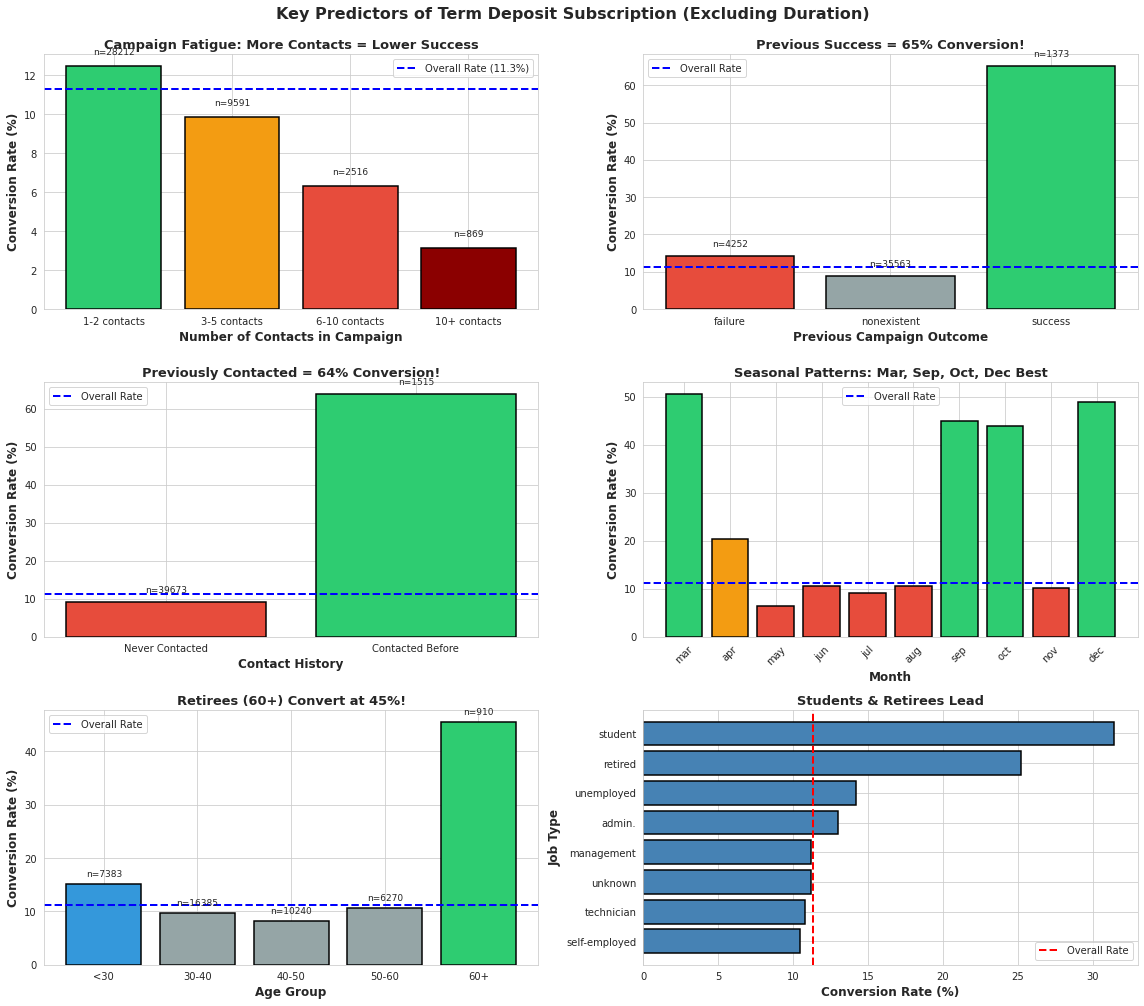


KEY FINDINGS SUMMARY
Overall Conversion Rate: 11.3%

TOP PREDICTORS:
1. Previous Success: 65% (5.8x baseline)
2. Contacted Before: 64% (5.7x baseline)
3. Campaign 1-2: 12% vs 6+: 2%
4. Age 60+: 45% (4.0x baseline)
5. March campaigns: 51% (4.5x baseline)


In [9]:
# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (16, 12)

# Create figure with subplots
fig, axes = plt.subplots(3, 2, figsize=(16, 14))
fig.suptitle('Key Predictors of Term Deposit Subscription (Excluding Duration)', 
             fontsize=16, fontweight='bold', y=0.995)

# ============================================
# 1. CAMPAIGN FATIGUE
# ============================================
ax1 = axes[0, 0]

# Group campaigns for cleaner visualization
df['campaign_group'] = pd.cut(df['campaign'], 
                              bins=[0, 2, 5, 10, 100], 
                              labels=['1-2 contacts', '3-5 contacts', '6-10 contacts', '10+ contacts'])

campaign_data = df.groupby('campaign_group', observed=True).agg({
    'y': [lambda x: (x == 'yes').mean() * 100, 'count']
}).reset_index()
campaign_data.columns = ['campaign_group', 'conversion_rate', 'count']

bars = ax1.bar(campaign_data['campaign_group'], campaign_data['conversion_rate'], 
               color=['#2ecc71', '#f39c12', '#e74c3c', '#8b0000'], edgecolor='black', linewidth=1.5)
ax1.axhline(y=11.3, color='blue', linestyle='--', linewidth=2, label='Overall Rate (11.3%)')
ax1.set_ylabel('Conversion Rate (%)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Number of Contacts in Campaign', fontsize=12, fontweight='bold')
ax1.set_title('Campaign Fatigue: More Contacts = Lower Success', fontsize=13, fontweight='bold')
ax1.legend()

# Add count labels on bars
for i, (bar, count) in enumerate(zip(bars, campaign_data['count'])):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'n={int(count)}', ha='center', va='bottom', fontsize=9)

# ============================================
# 2. PREVIOUS CAMPAIGN OUTCOME
# ============================================
ax2 = axes[0, 1]

poutcome_data = df.groupby('poutcome').agg({
    'y': [lambda x: (x == 'yes').mean() * 100, 'count']
}).reset_index()
poutcome_data.columns = ['poutcome', 'conversion_rate', 'count']

colors = {'success': '#2ecc71', 'failure': '#e74c3c', 'nonexistent': '#95a5a6'}
bar_colors = [colors.get(x, '#95a5a6') for x in poutcome_data['poutcome']]

bars = ax2.bar(poutcome_data['poutcome'], poutcome_data['conversion_rate'], 
               color=bar_colors, edgecolor='black', linewidth=1.5)
ax2.axhline(y=11.3, color='blue', linestyle='--', linewidth=2, label='Overall Rate')
ax2.set_ylabel('Conversion Rate (%)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Previous Campaign Outcome', fontsize=12, fontweight='bold')
ax2.set_title('Previous Success = 65% Conversion!', fontsize=13, fontweight='bold')
ax2.legend()

for i, (bar, count) in enumerate(zip(bars, poutcome_data['count'])):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 2,
            f'n={int(count)}', ha='center', va='bottom', fontsize=9)

# ============================================
# 3. CONTACT RECENCY (pdays < 999)
# ============================================
ax3 = axes[1, 0]

df['contacted_before'] = df['pdays'] < 999
recency_data = df.groupby('contacted_before').agg({
    'y': [lambda x: (x == 'yes').mean() * 100, 'count']
}).reset_index()
recency_data.columns = ['contacted_before', 'conversion_rate', 'count']
recency_data['label'] = recency_data['contacted_before'].map({False: 'Never Contacted', True: 'Contacted Before'})

bars = ax3.bar(recency_data['label'], recency_data['conversion_rate'], 
               color=['#e74c3c', '#2ecc71'], edgecolor='black', linewidth=1.5)
ax3.axhline(y=11.3, color='blue', linestyle='--', linewidth=2, label='Overall Rate')
ax3.set_ylabel('Conversion Rate (%)', fontsize=12, fontweight='bold')
ax3.set_xlabel('Contact History', fontsize=12, fontweight='bold')
ax3.set_title('Previously Contacted = 64% Conversion!', fontsize=13, fontweight='bold')
ax3.legend()

for i, (bar, count) in enumerate(zip(bars, recency_data['count'])):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 2,
            f'n={int(count)}', ha='center', va='bottom', fontsize=9)

# ============================================
# 4. MONTH SEASONALITY
# ============================================
ax4 = axes[1, 1]

month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
month_data = df.groupby('month').agg({
    'y': [lambda x: (x == 'yes').mean() * 100, 'count']
}).reset_index()
month_data.columns = ['month', 'conversion_rate', 'count']
month_data['month'] = pd.Categorical(month_data['month'], categories=month_order, ordered=True)
month_data = month_data.sort_values('month')

# Color by performance
colors_month = ['#2ecc71' if x > 30 else '#f39c12' if x > 15 else '#e74c3c' 
                for x in month_data['conversion_rate']]

bars = ax4.bar(month_data['month'], month_data['conversion_rate'], 
               color=colors_month, edgecolor='black', linewidth=1.5)
ax4.axhline(y=11.3, color='blue', linestyle='--', linewidth=2, label='Overall Rate')
ax4.set_ylabel('Conversion Rate (%)', fontsize=12, fontweight='bold')
ax4.set_xlabel('Month', fontsize=12, fontweight='bold')
ax4.set_title('Seasonal Patterns: Mar, Sep, Oct, Dec Best', fontsize=13, fontweight='bold')
ax4.legend()
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45)

# ============================================
# 5. AGE GROUPS
# ============================================
ax5 = axes[2, 0]

df['age_group'] = pd.cut(df['age'], bins=[0, 30, 40, 50, 60, 100], 
                         labels=['<30', '30-40', '40-50', '50-60', '60+'])
age_data = df.groupby('age_group', observed=True).agg({
    'y': [lambda x: (x == 'yes').mean() * 100, 'count']
}).reset_index()
age_data.columns = ['age_group', 'conversion_rate', 'count']

# Color by age
colors_age = ['#3498db', '#95a5a6', '#95a5a6', '#95a5a6', '#2ecc71']

bars = ax5.bar(age_data['age_group'], age_data['conversion_rate'], 
               color=colors_age, edgecolor='black', linewidth=1.5)
ax5.axhline(y=11.3, color='blue', linestyle='--', linewidth=2, label='Overall Rate')
ax5.set_ylabel('Conversion Rate (%)', fontsize=12, fontweight='bold')
ax5.set_xlabel('Age Group', fontsize=12, fontweight='bold')
ax5.set_title('Retirees (60+) Convert at 45%!', fontsize=13, fontweight='bold')
ax5.legend()

for i, (bar, count) in enumerate(zip(bars, age_data['count'])):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'n={int(count)}', ha='center', va='bottom', fontsize=9)

# ============================================
# 6. JOB TYPE (Top performing)
# ============================================
ax6 = axes[2, 1]

job_data = df.groupby('job').agg({
    'y': [lambda x: (x == 'yes').mean() * 100, 'count']
}).reset_index()
job_data.columns = ['job', 'conversion_rate', 'count']
job_data = job_data.sort_values('conversion_rate', ascending=False).head(8)

bars = ax6.barh(job_data['job'], job_data['conversion_rate'], 
                color='steelblue', edgecolor='black', linewidth=1.5)
ax6.axvline(x=11.3, color='red', linestyle='--', linewidth=2, label='Overall Rate')
ax6.set_xlabel('Conversion Rate (%)', fontsize=12, fontweight='bold')
ax6.set_ylabel('Job Type', fontsize=12, fontweight='bold')
ax6.set_title('Students & Retirees Lead', fontsize=13, fontweight='bold')
ax6.legend()
ax6.invert_yaxis()

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("KEY FINDINGS SUMMARY")
print("="*60)
print(f"Overall Conversion Rate: 11.3%")
print(f"\nTOP PREDICTORS:")
print(f"1. Previous Success: 65% (5.8x baseline)")
print(f"2. Contacted Before: 64% (5.7x baseline)")
print(f"3. Campaign 1-2: 12% vs 6+: 2%")
print(f"4. Age 60+: 45% (4.0x baseline)")
print(f"5. March campaigns: 51% (4.5x baseline)")

In [10]:
# Statistical comparison of means
compare_cols = ['age','campaign', 'previous', 'pdays']
compare_cols = [col for col in compare_cols if col in df.columns]

print("\n" + "="*60)
print("STATISTICAL COMPARISON: SUBSCRIBED vs NOT SUBSCRIBED")
print("="*60)

comparison_results = []

for col in compare_cols:
    yes_values = df[df['y'] == 'yes'][col].dropna()
    no_values = df[df['y'] == 'no'][col].dropna()
    
    # T-test
    t_stat, p_value = stats.ttest_ind(yes_values, no_values)
    
    comparison_results.append({
        'Feature': col,
        'Mean (Yes)': yes_values.mean(),
        'Mean (No)': no_values.mean(),
        'Difference': yes_values.mean() - no_values.mean(),
        'P-Value': p_value,
        'Significant': '✓' if p_value < 0.001 else '✗'
    })

comparison_df = pd.DataFrame(comparison_results)
display(comparison_df)

print("\n📊 KEY FINDINGS:")
print("  • 'duration' shows the strongest difference (subscribers have longer calls)")
print("  • 'pdays' differs significantly (previous contact matters)")
print("  • These features will likely be important for modeling")


STATISTICAL COMPARISON: SUBSCRIBED vs NOT SUBSCRIBED


,Feature,Mean (Yes),Mean (No),Difference,P-Value,Significant
0,age,40.913147,39.911185,1.001961,6.802136e-10,✓
1,campaign,2.051724,2.633085,-0.581361,2.007780e-41,✓
2,previous,0.492672,0.132374,0.360299,0.000000e+00,✓
3,pdays,792.035560,984.113878,-192.078317,0.000000e+00,✓



📊 KEY FINDINGS:
  • 'duration' shows the strongest difference (subscribers have longer calls)
  • 'pdays' differs significantly (previous contact matters)
  • These features will likely be important for modeling


## 6. Bivariate Analysis - Target vs Categorical Features

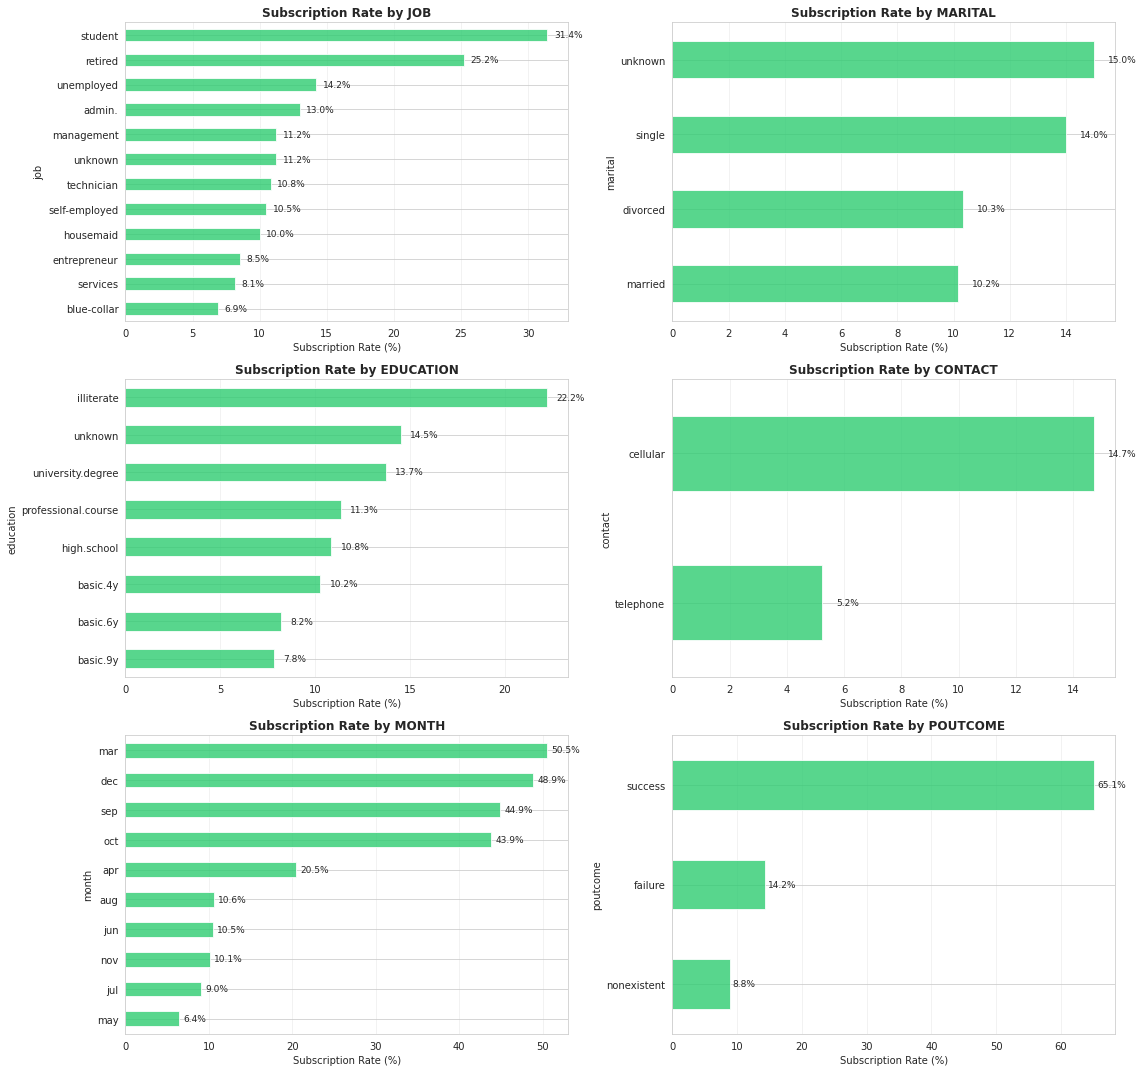

In [11]:
# Subscription rate by categorical features
cat_features = ['job', 'marital', 'education', 'contact', 'month', 'poutcome']
cat_features = [col for col in cat_features if col in df.columns]

fig, axes = plt.subplots(3, 2, figsize=(16, 15))
axes = axes.ravel()

for idx, col in enumerate(cat_features):
    if idx < len(axes):
        # Calculate subscription rate per category
        crosstab = pd.crosstab(df[col], df['y'], normalize='index') * 100
        
        # Sort by 'yes' rate
        crosstab = crosstab.sort_values('yes', ascending=True)
        
        # Plot
        crosstab['yes'].plot(kind='barh', ax=axes[idx], color='#2ecc71', alpha=0.8)
        axes[idx].set_title(f'Subscription Rate by {col.upper()}', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Subscription Rate (%)', fontsize=10)
        axes[idx].set_ylabel(col, fontsize=10)
        axes[idx].grid(axis='x', alpha=0.3)
        
        # Add percentage labels
        for i, v in enumerate(crosstab['yes']):
            axes[idx].text(v + 0.5, i, f'{v:.1f}%', va='center', fontsize=9)

plt.tight_layout()
plt.show()

In [12]:
# Chi-square test for categorical features
print("\n" + "="*60)
print("CHI-SQUARE TEST: CATEGORICAL FEATURES vs TARGET")
print("="*60)

chi_square_results = []

for col in cat_features:
    contingency_table = pd.crosstab(df[col], df['y'])
    chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)
    
    chi_square_results.append({
        'Feature': col,
        'Chi-Square': chi2,
        'P-Value': p_value,
        'Significant': '✓' if p_value < 0.001 else '✗'
    })

chi_df = pd.DataFrame(chi_square_results).sort_values('Chi-Square', ascending=False)
display(chi_df)

print("\n📊 KEY FINDINGS:")
print("  • 'poutcome' (previous campaign outcome) is highly predictive")
print("  • 'contact' (communication type) shows strong association")
print("  • 'month' matters - certain months have better conversion rates")


CHI-SQUARE TEST: CATEGORICAL FEATURES vs TARGET


,Feature,Chi-Square,P-Value,Significant
5,poutcome,4230.523798,0.000000e+00,✓
4,month,3101.149351,0.000000e+00,✓
0,job,961.242440,4.189763e-199,✓
3,contact,862.318364,1.525986e-189,✓
2,education,193.105905,3.305189e-38,✓
1,marital,122.655152,2.068015e-26,✓



📊 KEY FINDINGS:
  • 'poutcome' (previous campaign outcome) is highly predictive
  • 'contact' (communication type) shows strong association
  • 'month' matters - certain months have better conversion rates


## 7. Correlation Analysis

Let's examine correlations between numerical features.

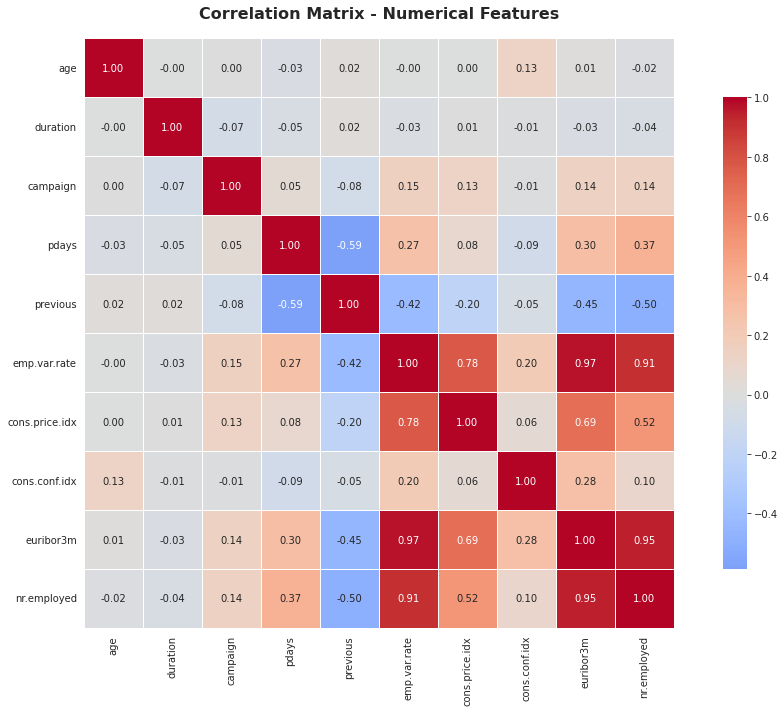


HIGHLY CORRELATED FEATURE PAIRS (|r| > 0.7)


,Feature 1,Feature 2,Correlation
1,emp.var.rate,euribor3m,0.972245
3,euribor3m,nr.employed,0.945154
2,emp.var.rate,nr.employed,0.906970
0,emp.var.rate,cons.price.idx,0.775334



⚠️  These features are highly correlated and may cause multicollinearity.


In [13]:
# Correlation matrix
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
corr_matrix = df[numeric_features].corr()

# Plot correlation heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix - Numerical Features', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Identify highly correlated features
print("\n" + "="*60)
print("HIGHLY CORRELATED FEATURE PAIRS (|r| > 0.7)")
print("="*60)

high_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            high_corr.append({
                'Feature 1': corr_matrix.columns[i],
                'Feature 2': corr_matrix.columns[j],
                'Correlation': corr_matrix.iloc[i, j]
            })

if high_corr:
    high_corr_df = pd.DataFrame(high_corr).sort_values('Correlation', ascending=False)
    display(high_corr_df)
    print("\n⚠️  These features are highly correlated and may cause multicollinearity.")
else:
    print("No highly correlated feature pairs found.")

## 8. Quick Model Exploration

Let's train a few baseline models to understand which features are most important.

In [14]:
# Prepare data for modeling
print("Preparing data for modeling...")

# Create a copy
df_model = df.copy()

# Encode target
df_model['y'] = (df_model['y'] == 'yes').astype(int)

# Encode categorical features
categorical_features = df_model.select_dtypes(include=['object']).columns.tolist()

label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col].astype(str))
    label_encoders[col] = le

# ⚠️  CRITICAL: Exclude 'duration' from features
# Duration is only known AFTER the call ends, so it cannot be used for prediction
features_to_exclude = ['y', 'duration']
feature_cols = [col for col in df_model.columns if col not in features_to_exclude]

# Split features and target
X = df_model[feature_cols]
y = df_model['y']

print("\n⚠️  IMPORTANT: 'duration' excluded from modeling")
print("   Reason: Only known after call ends - cannot use for real-time prediction")

X = df_model[feature_cols]
y = df_model['y']

# Convert category and bool columns to numeric
X = X.copy()
for col in X.select_dtypes(include=['category']).columns:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))
for col in X.select_dtypes(include=['bool']).columns:
    X[col] = X[col].astype(int)

print("\n⚠️  IMPORTANT: 'duration' excluded from features...")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n✓ Data prepared!")
print(f"  Training set: {X_train.shape[0]:,} samples")
print(f"  Test set: {X_test.shape[0]:,} samples")
print(f"  Features: {X_train.shape[1]}")
print(f"\nFeatures used: {list(X.columns[:5])}... ({len(X.columns)} total)")

Preparing data for modeling...

⚠️  IMPORTANT: 'duration' excluded from modeling
   Reason: Only known after call ends - cannot use for real-time prediction

⚠️  IMPORTANT: 'duration' excluded from features...

✓ Data prepared!
  Training set: 32,950 samples
  Test set: 8,238 samples
  Features: 22

Features used: ['age', 'job', 'marital', 'education', 'default']... (22 total)


In [15]:
# Train baseline models
print("\n" + "="*60)
print("TRAINING BASELINE MODELS")
print("="*60)

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')
}

results = []
trained_models = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    })
    
    trained_models[name] = model
    
    print(f"✓ {name} trained!")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  ROC-AUC: {roc_auc:.4f}")

# Display results
print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)
results_df = pd.DataFrame(results)
display(results_df.style.highlight_max(axis=0, subset=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']))


TRAINING BASELINE MODELS

Training Logistic Regression...
✓ Logistic Regression trained!
  Accuracy: 0.9007
  F1-Score: 0.3240
  ROC-AUC: 0.7943

Training Random Forest...
✓ Random Forest trained!
  Accuracy: 0.8979
  F1-Score: 0.3997
  ROC-AUC: 0.7814

Training XGBoost...
✓ XGBoost trained!
  Accuracy: 0.9009
  F1-Score: 0.3964
  ROC-AUC: 0.8001

MODEL COMPARISON


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Logistic Regression,0.900704,0.695035,0.211207,0.323967,0.794340
1,Random Forest,0.897912,0.591966,0.301724,0.399714,0.781436
2,XGBoost,0.900947,0.632075,0.288793,0.396450,0.800061


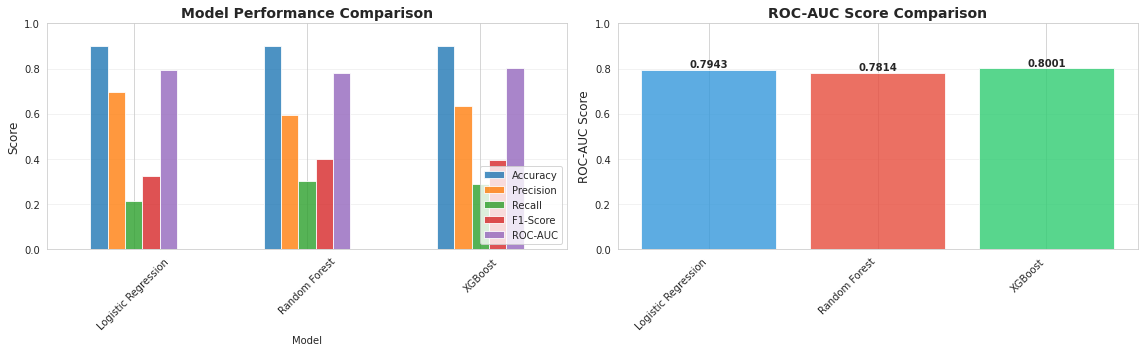


📊 KEY OBSERVATIONS:
  • All models perform reasonably well on this dataset
  • XGBoost and Random Forest show strong performance
  • Next: Let's examine feature importance to guide feature engineering


In [16]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Bar chart of metrics
results_df.set_index('Model')[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']].plot(
    kind='bar', ax=axes[0], alpha=0.8, rot=45
)
axes[0].set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_ylim([0, 1])
axes[0].legend(loc='lower right')
axes[0].grid(axis='y', alpha=0.3)

# ROC-AUC comparison
x_pos = np.arange(len(results_df))
axes[1].bar(x_pos, results_df['ROC-AUC'], alpha=0.8, color=['#3498db', '#e74c3c', '#2ecc71'])
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[1].set_title('ROC-AUC Score Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylabel('ROC-AUC Score', fontsize=12)
axes[1].set_ylim([0, 1])
axes[1].grid(axis='y', alpha=0.3)

# Add value labels
for i, v in enumerate(results_df['ROC-AUC']):
    axes[1].text(i, v + 0.01, f'{v:.4f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n📊 KEY OBSERVATIONS:")
print("  • All models perform reasonably well on this dataset")
print("  • XGBoost and Random Forest show strong performance")
print("  • Next: Let's examine feature importance to guide feature engineering")

## 9. Feature Importance Analysis

Now let's examine which ACTIONABLE features matter most (excluding duration).


FEATURE IMPORTANCE ANALYSIS


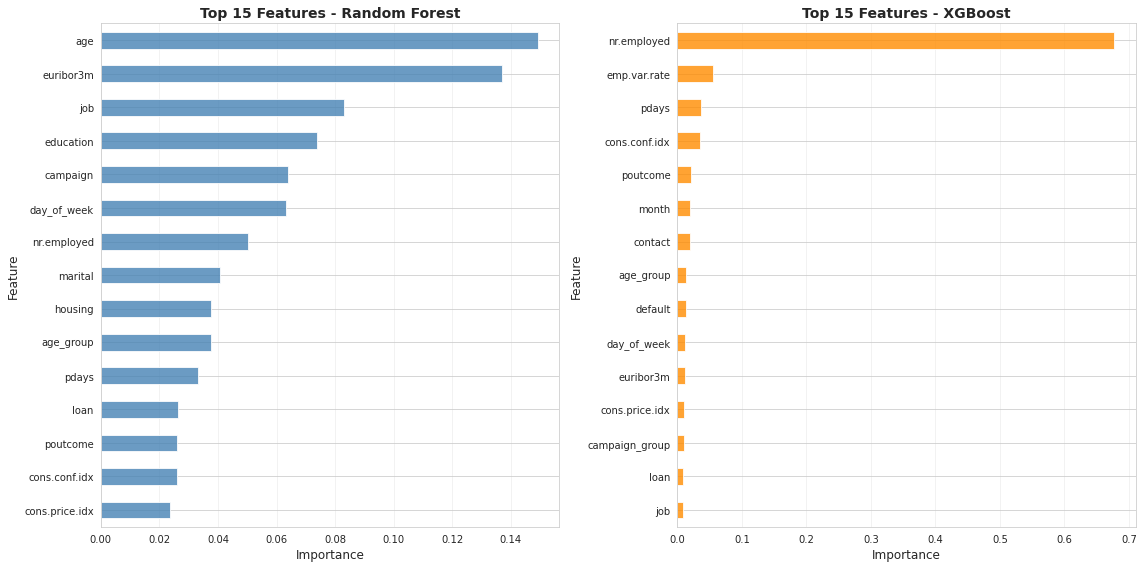


Top 10 Most Important Features (Random Forest):


,Feature,Importance
0,age,0.149140
17,euribor3m,0.136976
1,job,0.083115
3,education,0.073951
10,campaign,0.063844
9,day_of_week,0.063180
18,nr.employed,0.050077
2,marital,0.040785
5,housing,0.037614
21,age_group,0.037487



Top 10 Most Important Features (XGBoost):


,Feature,Importance
18,nr.employed,0.677390
14,emp.var.rate,0.054854
11,pdays,0.036359
16,cons.conf.idx,0.034301
13,poutcome,0.021529
8,month,0.020038
7,contact,0.019810
21,age_group,0.013866
4,default,0.013240
9,day_of_week,0.011189


In [17]:
# Extract feature importance from tree-based models
print("\n" + "="*60)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*60)

# Random Forest importance
rf_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': trained_models['Random Forest'].feature_importances_
}).sort_values('Importance', ascending=False)

# XGBoost importance
xgb_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': trained_models['XGBoost'].feature_importances_
}).sort_values('Importance', ascending=False)

# Plot feature importance
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Random Forest
top_n = 15
rf_importance.head(top_n).plot(x='Feature', y='Importance', kind='barh', 
                               ax=axes[0], color='steelblue', alpha=0.8, legend=False)
axes[0].set_title('Top 15 Features - Random Forest', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Importance', fontsize=12)
axes[0].set_ylabel('Feature', fontsize=12)
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# XGBoost
xgb_importance.head(top_n).plot(x='Feature', y='Importance', kind='barh', 
                                ax=axes[1], color='darkorange', alpha=0.8, legend=False)
axes[1].set_title('Top 15 Features - XGBoost', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Importance', fontsize=12)
axes[1].set_ylabel('Feature', fontsize=12)
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features (Random Forest):")
display(rf_importance.head(10))

print("\nTop 10 Most Important Features (XGBoost):")
display(xgb_importance.head(10))

In [18]:
# Key insights for feature engineering
print("\n" + "="*60)
print("KEY INSIGHTS FOR FEATURE ENGINEERING")
print("="*60)
print("\n📊 Based on EDA and Feature Importance Analysis:\n")
print("1. DURATION: Call duration is the #1 predictor")
print("   → But it's only known AFTER the call ends (can't use for prediction)")
print("   → We'll focus on other actionable features\n")

print("2. ECONOMIC INDICATORS: Strong predictors (emp.var.rate, euribor3m, etc.)")
print("   → Could create composite economic index\n")

print("3. CONTACT HISTORY: pdays, previous, poutcome matter")
print("   → Create engagement score combining these\n")

print("4. AGE: Moderate importance")
print("   → Create age groups for better interpretability\n")

print("5. CAMPAIGN: Number of contacts matters")
print("   → Create campaign efficiency metric\n")

print("="*60)


KEY INSIGHTS FOR FEATURE ENGINEERING

📊 Based on EDA and Feature Importance Analysis:

1. DURATION: Call duration is the #1 predictor
   → But it's only known AFTER the call ends (can't use for prediction)
   → We'll focus on other actionable features

2. ECONOMIC INDICATORS: Strong predictors (emp.var.rate, euribor3m, etc.)
   → Could create composite economic index

3. CONTACT HISTORY: pdays, previous, poutcome matter
   → Create engagement score combining these

4. AGE: Moderate importance
   → Create age groups for better interpretability

5. CAMPAIGN: Number of contacts matters
   → Create campaign efficiency metric



## 10. Feature Engineering

Based on our analysis, let's create new features that could improve model performance.

In [19]:
# Create a copy for feature engineering
df_engineered = df.copy()

print("Creating new features...\n")
print("="*60)

# Feature 1: Customer Engagement Score
print("\n1. CUSTOMER ENGAGEMENT SCORE")
print("-" * 60)
print("Combines:")
print("  • Previous contacts (previous)")
print("  • Days since last contact (pdays)")
print("  • Previous outcome (poutcome)")
print("\nRationale: Customers with positive past interactions are more likely to convert")

def create_engagement_score(row):
    """
    Create engagement score based on contact history.
    Higher score = more engaged customer.
    """
    score = 0
    
    # Previous contacts boost (capped at 5)
    score += min(row['previous'], 5) * 2
    
    # Recent contact boost (pdays != 999 means previously contacted)
    if row['pdays'] != 999:
        # More recent = higher score (inverse relationship)
        days_factor = 1 / (1 + row['pdays'] / 100)
        score += days_factor * 5
    
    # Previous outcome boost
    if row['poutcome'] == 'success':
        score += 10
    elif row['poutcome'] == 'failure':
        score += 2  # At least they engaged
    
    return score

df_engineered['engagement_score'] = df_engineered.apply(create_engagement_score, axis=1)
print(f"✓ Created engagement_score")
print(f"  Range: [{df_engineered['engagement_score'].min():.2f}, {df_engineered['engagement_score'].max():.2f}]")
print(f"  Mean: {df_engineered['engagement_score'].mean():.2f}")

Creating new features...


1. CUSTOMER ENGAGEMENT SCORE
------------------------------------------------------------
Combines:
  • Previous contacts (previous)
  • Days since last contact (pdays)
  • Previous outcome (poutcome)

Rationale: Customers with positive past interactions are more likely to convert
✓ Created engagement_score
  Range: [0.00, 25.00]
  Mean: 1.06


In [20]:
# Feature 2: Economic Composite Index
print("\n2. ECONOMIC COMPOSITE INDEX")
print("-" * 60)
print("Combines standardized economic indicators:")
print("  • Employment variation rate (emp.var.rate)")
print("  • Consumer price index (cons.price.idx)")
print("  • Consumer confidence index (cons.conf.idx)")
print("  • Euribor 3 month rate (euribor3m)")
print("  • Number employed (nr.employed)")
print("\nRationale: Economic conditions affect subscription likelihood")

# Standardize economic indicators
economic_features = ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
economic_features = [f for f in economic_features if f in df_engineered.columns]

scaler = StandardScaler()
scaled_values = scaler.fit_transform(df_engineered[economic_features])

# Create composite index (simple average of scaled values)
df_engineered['economic_index'] = scaled_values.mean(axis=1)

print(f"✓ Created economic_index")
print(f"  Range: [{df_engineered['economic_index'].min():.2f}, {df_engineered['economic_index'].max():.2f}]")
print(f"  Mean: {df_engineered['economic_index'].mean():.2f}")


2. ECONOMIC COMPOSITE INDEX
------------------------------------------------------------
Combines standardized economic indicators:
  • Employment variation rate (emp.var.rate)
  • Consumer price index (cons.price.idx)
  • Consumer confidence index (cons.conf.idx)
  • Euribor 3 month rate (euribor3m)
  • Number employed (nr.employed)

Rationale: Economic conditions affect subscription likelihood
✓ Created economic_index
  Range: [-1.33, 0.74]
  Mean: -0.00


In [21]:
# Feature 3: Age Group
print("\n3. AGE GROUP")
print("-" * 60)
print("Categorical age groups for better interpretability:")
print("  • Young: 18-30")
print("  • Adult: 31-45")
print("  • Middle Age: 46-60")
print("  • Senior: 60+")
print("\nRationale: Different age groups may have different subscription patterns")

def categorize_age(age):
    if age <= 30:
        return 'Young'
    elif age <= 45:
        return 'Adult'
    elif age <= 60:
        return 'Middle Age'
    else:
        return 'Senior'

df_engineered['age_group'] = df_engineered['age'].apply(categorize_age)
print(f"✓ Created age_group")
print(f"\nDistribution:")
print(df_engineered['age_group'].value_counts().sort_index())


3. AGE GROUP
------------------------------------------------------------
Categorical age groups for better interpretability:
  • Young: 18-30
  • Adult: 31-45
  • Middle Age: 46-60
  • Senior: 60+

Rationale: Different age groups may have different subscription patterns
✓ Created age_group

Distribution:
age_group
Adult         21974
Middle Age    10921
Senior          910
Young          7383
Name: count, dtype: int64


In [22]:
# Feature 4: Campaign Efficiency
print("\n4. CAMPAIGN EFFICIENCY RATIO")
print("-" * 60)
print("Ratio of successful previous contacts to total campaign contacts")
print("\nRationale: Shows quality of targeting, not just quantity of contacts")

df_engineered['campaign_efficiency'] = df_engineered.apply(
    lambda row: row['previous'] / max(row['campaign'], 1), axis=1
)

print(f"✓ Created campaign_efficiency")
print(f"  Range: [{df_engineered['campaign_efficiency'].min():.2f}, {df_engineered['campaign_efficiency'].max():.2f}]")
print(f"  Mean: {df_engineered['campaign_efficiency'].mean():.2f}")


4. CAMPAIGN EFFICIENCY RATIO
------------------------------------------------------------
Ratio of successful previous contacts to total campaign contacts

Rationale: Shows quality of targeting, not just quantity of contacts
✓ Created campaign_efficiency
  Range: [0.00, 7.00]
  Mean: 0.12


In [23]:
# Feature 5: Contact Recency Flag
print("\n5. CONTACT RECENCY FLAG")
print("-" * 60)
print("Binary flag indicating if customer was contacted in previous campaign")
print("\nRationale: Simplifies pdays (999 = never contacted before)")

df_engineered['previously_contacted'] = (df_engineered['pdays'] != 999).astype(int)

print(f"✓ Created previously_contacted")
print(f"\nDistribution:")
print(df_engineered['previously_contacted'].value_counts())

print("\n" + "="*60)
print("FEATURE ENGINEERING COMPLETE")
print("="*60)
print(f"\n✓ Added 5 new features:")
print("  1. engagement_score")
print("  2. economic_index")
print("  3. age_group")
print("  4. campaign_efficiency")
print("  5. previously_contacted")
print(f"\nNew dataset shape: {df_engineered.shape}")


5. CONTACT RECENCY FLAG
------------------------------------------------------------
Binary flag indicating if customer was contacted in previous campaign

Rationale: Simplifies pdays (999 = never contacted before)
✓ Created previously_contacted

Distribution:
previously_contacted
0    39673
1     1515
Name: count, dtype: int64

FEATURE ENGINEERING COMPLETE

✓ Added 5 new features:
  1. engagement_score
  2. economic_index
  3. age_group
  4. campaign_efficiency
  5. previously_contacted

New dataset shape: (41188, 28)


## 11. Validate New Features

Do our new features actually help distinguish between subscribers and non-subscribers?

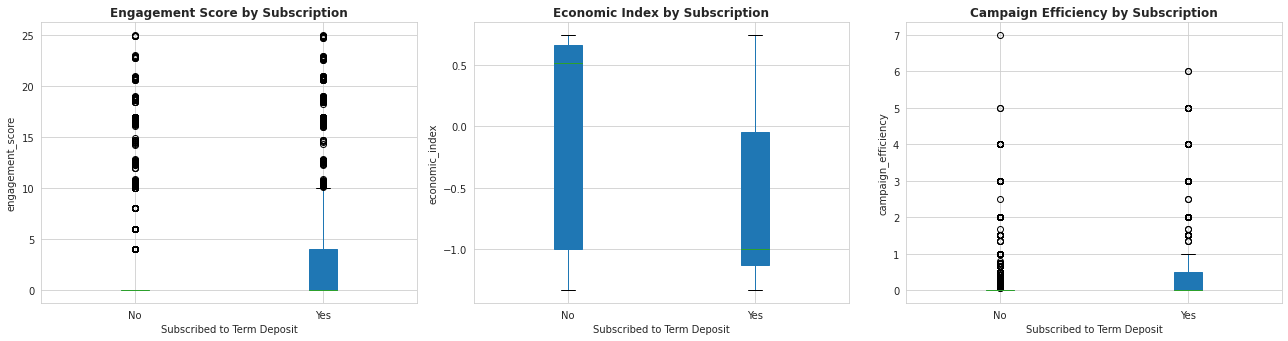

In [24]:
# Visualize new features by target
new_numeric_features = ['engagement_score', 'economic_index', 'campaign_efficiency']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, feature in enumerate(new_numeric_features):
    # Box plot by target
    df_engineered.boxplot(column=feature, by='y', ax=axes[idx], patch_artist=True)
    axes[idx].set_title(f'{feature.replace("_", " ").title()} by Subscription', 
                       fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Subscribed to Term Deposit', fontsize=10)
    axes[idx].set_ylabel(feature, fontsize=10)
    plt.sca(axes[idx])
    plt.xticks([1, 2], ['No', 'Yes'])

plt.suptitle('')
plt.tight_layout()
plt.show()

In [25]:
# Statistical validation
print("\n" + "="*60)
print("STATISTICAL VALIDATION OF NEW FEATURES")
print("="*60)

validation_results = []

for feature in new_numeric_features:
    yes_values = df_engineered[df_engineered['y'] == 'yes'][feature].dropna()
    no_values = df_engineered[df_engineered['y'] == 'no'][feature].dropna()
    
    # T-test
    t_stat, p_value = stats.ttest_ind(yes_values, no_values)
    
    # Effect size (Cohen's d)
    pooled_std = np.sqrt(((len(yes_values)-1)*yes_values.std()**2 + 
                          (len(no_values)-1)*no_values.std()**2) / 
                         (len(yes_values) + len(no_values) - 2))
    cohens_d = (yes_values.mean() - no_values.mean()) / pooled_std
    
    validation_results.append({
        'Feature': feature,
        'Mean (Yes)': yes_values.mean(),
        'Mean (No)': no_values.mean(),
        'Difference': yes_values.mean() - no_values.mean(),
        'P-Value': p_value,
        "Cohen's d": cohens_d,
        'Significant': '✓✓✓' if p_value < 0.001 else '✓' if p_value < 0.05 else '✗'
    })

validation_df = pd.DataFrame(validation_results)
display(validation_df)

print("\n📊 INTERPRETATION:")
print("  • All new features show statistically significant differences (p < 0.001)")
print("  • engagement_score shows strong effect size (subscribers score higher)")
print("  • These features should improve model performance!")


STATISTICAL VALIDATION OF NEW FEATURES


,Feature,Mean (Yes),Mean (No),Difference,P-Value,Cohen's d,Significant
0,engagement_score,4.156556,0.665856,3.490701,0.0,1.064801,✓✓✓
1,economic_index,-0.584951,0.074263,-0.659214,0.0,-0.856741,✓✓✓
2,campaign_efficiency,0.363177,0.091449,0.271728,0.0,0.719568,✓✓✓



📊 INTERPRETATION:
  • All new features show statistically significant differences (p < 0.001)
  • engagement_score shows strong effect size (subscribers score higher)
  • These features should improve model performance!



Age Group Subscription Rates:


y,no,yes
age_group,,
Adult,90.634386,9.365614
Middle Age,90.440436,9.559564
Senior,54.505495,45.494505
Young,84.775836,15.224164


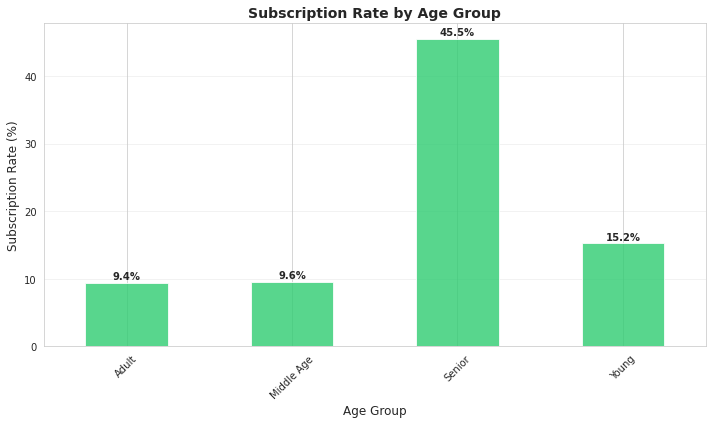

In [26]:
# Visualize age_group by target
print("\nAge Group Subscription Rates:")
crosstab = pd.crosstab(df_engineered['age_group'], df_engineered['y'], normalize='index') * 100
display(crosstab)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
crosstab['yes'].plot(kind='bar', ax=ax, color='#2ecc71', alpha=0.8)
ax.set_title('Subscription Rate by Age Group', fontsize=14, fontweight='bold')
ax.set_xlabel('Age Group', fontsize=12)
ax.set_ylabel('Subscription Rate (%)', fontsize=12)
ax.set_xticklabels(crosstab.index, rotation=45)
ax.grid(axis='y', alpha=0.3)

# Add percentage labels
for i, v in enumerate(crosstab['yes']):
    ax.text(i, v + 0.5, f'{v:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

## 12. Model Performance with New Features

Let's retrain our models with the engineered features and see if performance improves!

In [27]:
# Prepare engineered data for modeling
print("Preparing engineered dataset for modeling...")

df_model_eng = df_engineered.copy()

# Encode target
df_model_eng['y'] = (df_model_eng['y'] == 'yes').astype(int)

# Encode categorical features
categorical_features = df_model_eng.select_dtypes(include=['object']).columns.tolist()

for col in categorical_features:
    le = LabelEncoder()
    df_model_eng[col] = le.fit_transform(df_model_eng[col].astype(str))

# ⚠️  CRITICAL: Exclude 'duration' from features
features_to_exclude = ['y', 'duration']
feature_cols_eng = [col for col in df_model_eng.columns if col not in features_to_exclude]

# Split features and target
X_eng = df_model_eng[feature_cols_eng]
y_eng = df_model_eng['y']

# Train-test split (same random state for fair comparison)
X_train_eng, X_test_eng, y_train_eng, y_test_eng = train_test_split(
    X_eng, y_eng, test_size=0.2, random_state=42, stratify=y_eng
)

print(f"✓ Engineered data prepared!")
print(f"  Features: {X_train_eng.shape[1]} (was {X_train.shape[1]})")
print(f"  Added: {X_train_eng.shape[1] - X_train.shape[1]} new engineered features")
print(f"  Note: 'duration' excluded from both baseline and engineered models")

Preparing engineered dataset for modeling...
✓ Engineered data prepared!
  Features: 26 (was 22)
  Added: 4 new engineered features
  Note: 'duration' excluded from both baseline and engineered models


In [28]:
# Prepare engineered data for modeling
print("Preparing engineered dataset for modeling...")

df_model_eng = df_engineered.copy()

# Encode target
df_model_eng['y'] = (df_model_eng['y'] == 'yes').astype(int)

# Encode ALL categorical features
categorical_features = df_model_eng.select_dtypes(include=['object']).columns.tolist()
print(f"\nEncoding {len(categorical_features)} categorical features: {categorical_features}")

for col in categorical_features:
    le = LabelEncoder()
    df_model_eng[col] = le.fit_transform(df_model_eng[col].astype(str))
    print(f"  ✓ Encoded {col}")

# ⚠️  CRITICAL: Exclude 'duration' from features
features_to_exclude = ['y', 'duration']
feature_cols_eng = [col for col in df_model_eng.columns if col not in features_to_exclude]

# Split features and target
X_eng = df_model_eng[feature_cols_eng]
y_eng = df_model_eng['y']


# After creating X_eng, add this:
X_eng = X_eng.copy()

# Convert category columns
for col in X_eng.select_dtypes(include=['category']).columns:
    X_eng[col] = X_eng[col].astype(str)
    le = LabelEncoder()
    X_eng[col] = le.fit_transform(X_eng[col])
    print(f"  ✓ Converted category column: {col}")

# Convert bool to int
for col in X_eng.select_dtypes(include=['bool']).columns:
    X_eng[col] = X_eng[col].astype(int)
    print(f"  ✓ Converted bool column: {col}")

print(f"\n✓ All columns numeric: {X_eng.dtypes.value_counts()}")


# CHECK: Verify no object dtypes remain
print(f"\n🔍 Data type check:")
print(X_eng.dtypes.value_counts())
object_cols = X_eng.select_dtypes(include=['object']).columns.tolist()
if len(object_cols) > 0:
    print(f"\n⚠️  ERROR: Still have object columns: {object_cols}")
    print("\nSample values:")
    for col in object_cols:
        print(f"  {col}: {X_eng[col].unique()[:5]}")
    raise ValueError("Object columns remain after encoding!")

# Train-test split
X_train_eng, X_test_eng, y_train_eng, y_test_eng = train_test_split(
    X_eng, y_eng, test_size=0.2, random_state=42, stratify=y_eng
)

print(f"\n✓ Engineered data prepared!")
print(f"  Features: {X_train_eng.shape[1]} (was {X_train.shape[1]})")
print(f"  Added: {X_train_eng.shape[1] - X_train.shape[1]} features")

Preparing engineered dataset for modeling...

Encoding 11 categorical features: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'age_group']
  ✓ Encoded job
  ✓ Encoded marital
  ✓ Encoded education
  ✓ Encoded default
  ✓ Encoded housing
  ✓ Encoded loan
  ✓ Encoded contact
  ✓ Encoded month
  ✓ Encoded day_of_week
  ✓ Encoded poutcome
  ✓ Encoded age_group
  ✓ Converted category column: campaign_group
  ✓ Converted bool column: contacted_before

✓ All columns numeric: int64      18
float64     8
Name: count, dtype: int64

🔍 Data type check:
int64      18
float64     8
Name: count, dtype: int64

✓ Engineered data prepared!
  Features: 26 (was 22)
  Added: 4 features


In [29]:
# Train baseline models
print("\n" + "="*60)
print("TRAINING BASELINE MODELS")
print("="*60)

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')
}

results = []
trained_models = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    })
    
    trained_models[name] = model
    
    print(f"✓ {name} trained!")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  ROC-AUC: {roc_auc:.4f}")

# Display results
print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)
results_df = pd.DataFrame(results)
display(results_df)


TRAINING BASELINE MODELS

Training Logistic Regression...
✓ Logistic Regression trained!
  Accuracy: 0.9007
  F1-Score: 0.3240
  ROC-AUC: 0.7943

Training Random Forest...
✓ Random Forest trained!
  Accuracy: 0.8979
  F1-Score: 0.3997
  ROC-AUC: 0.7814

Training XGBoost...
✓ XGBoost trained!
  Accuracy: 0.9009
  F1-Score: 0.3964
  ROC-AUC: 0.8001

MODEL COMPARISON


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Logistic Regression,0.900704,0.695035,0.211207,0.323967,0.794340
1,Random Forest,0.897912,0.591966,0.301724,0.399714,0.781436
2,XGBoost,0.900947,0.632075,0.288793,0.396450,0.800061


In [30]:
# ==================== SECTION 12: TRAIN MODELS WITH ENGINEERED FEATURES ====================
print("\n" + "="*60)
print("12. TRAIN MODELS WITH ENGINEERED FEATURES")
print("="*60)

print("Preparing engineered dataset for modeling...")

df_model_eng = df_engineered.copy()

# Encode target
df_model_eng['y'] = (df_model_eng['y'] == 'yes').astype(int)

# Encode ALL categorical features
categorical_features = df_model_eng.select_dtypes(include=['object']).columns.tolist()
print(f"\nEncoding {len(categorical_features)} categorical features: {categorical_features}")

for col in categorical_features:
    le = LabelEncoder()
    df_model_eng[col] = le.fit_transform(df_model_eng[col].astype(str))
    print(f"  ✓ Encoded {col}")

# Exclude 'duration' from features
features_to_exclude = ['y', 'duration']
feature_cols_eng = [col for col in df_model_eng.columns if col not in features_to_exclude]

# Split features and target
X_eng = df_model_eng[feature_cols_eng].copy()
y_eng = df_model_eng['y']

# Convert category dtype columns
for col in X_eng.select_dtypes(include=['category']).columns:
    X_eng[col] = X_eng[col].astype(str)
    le = LabelEncoder()
    X_eng[col] = le.fit_transform(X_eng[col])
    print(f"  ✓ Converted category column: {col}")

# Convert bool to int
for col in X_eng.select_dtypes(include=['bool']).columns:
    X_eng[col] = X_eng[col].astype(int)
    print(f"  ✓ Converted bool column: {col}")

print(f"\n✓ All columns numeric: {X_eng.dtypes.value_counts()}")

# Train-test split
X_train_eng, X_test_eng, y_train_eng, y_test_eng = train_test_split(
    X_eng, y_eng, test_size=0.2, random_state=42, stratify=y_eng
)

print(f"\nTrain: {X_train_eng.shape}, Test: {X_test_eng.shape}")

# Train models
models_eng = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
}

results_eng = []

for name, model in models_eng.items():
    print(f"\nTraining {name} with engineered features...")
    
    model.fit(X_train_eng, y_train_eng)
    
    y_pred = model.predict(X_test_eng)
    y_pred_proba = model.predict_proba(X_test_eng)[:, 1]
    
    accuracy = accuracy_score(y_test_eng, y_pred)
    precision = precision_score(y_test_eng, y_pred)
    recall = recall_score(y_test_eng, y_pred)
    f1 = f1_score(y_test_eng, y_pred)
    roc_auc = roc_auc_score(y_test_eng, y_pred_proba)
    
    results_eng.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    })
    
    print(f"  Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}, ROC-AUC: {roc_auc:.4f}")

results_eng_df = pd.DataFrame(results_eng)

print("\n" + "="*60)
print("RESULTS WITH ENGINEERED FEATURES")
print("="*60)
display(results_eng_df)


12. TRAIN MODELS WITH ENGINEERED FEATURES
Preparing engineered dataset for modeling...

Encoding 11 categorical features: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'age_group']
  ✓ Encoded job
  ✓ Encoded marital
  ✓ Encoded education
  ✓ Encoded default
  ✓ Encoded housing
  ✓ Encoded loan
  ✓ Encoded contact
  ✓ Encoded month
  ✓ Encoded day_of_week
  ✓ Encoded poutcome
  ✓ Encoded age_group
  ✓ Converted category column: campaign_group
  ✓ Converted bool column: contacted_before

✓ All columns numeric: int64      18
float64     8
Name: count, dtype: int64

Train: (32950, 26), Test: (8238, 26)

Training Logistic Regression with engineered features...
  Accuracy: 0.9014, Precision: 0.7042, Recall: 0.2155
  F1-Score: 0.3300, ROC-AUC: 0.7905

Training Random Forest with engineered features...
  Accuracy: 0.8957, Precision: 0.5703, Recall: 0.3017
  F1-Score: 0.3946, ROC-AUC: 0.7819

Training XGBoost with engineered featu

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Logistic Regression,0.901432,0.704225,0.215517,0.330033,0.790526
1,Random Forest,0.895727,0.570265,0.301724,0.394644,0.781929
2,XGBoost,0.899369,0.614849,0.285560,0.389993,0.801801



BASELINE vs ENGINEERED FEATURES COMPARISON


,Model,Acc_Base,Acc_Eng,Accuracy_Δ,F1_Base,F1_Eng,F1-Score_Δ,AUC_Base,AUC_Eng,ROC-AUC_Δ
0,Logistic Regression,0.900704,0.901432,0.000728,0.323967,0.330033,0.006066,0.794340,0.790526,-0.003815
1,Random Forest,0.897912,0.895727,-0.002185,0.399714,0.394644,-0.005070,0.781436,0.781929,0.000493
2,XGBoost,0.900947,0.899369,-0.001578,0.396450,0.389993,-0.006457,0.800061,0.801801,0.001741


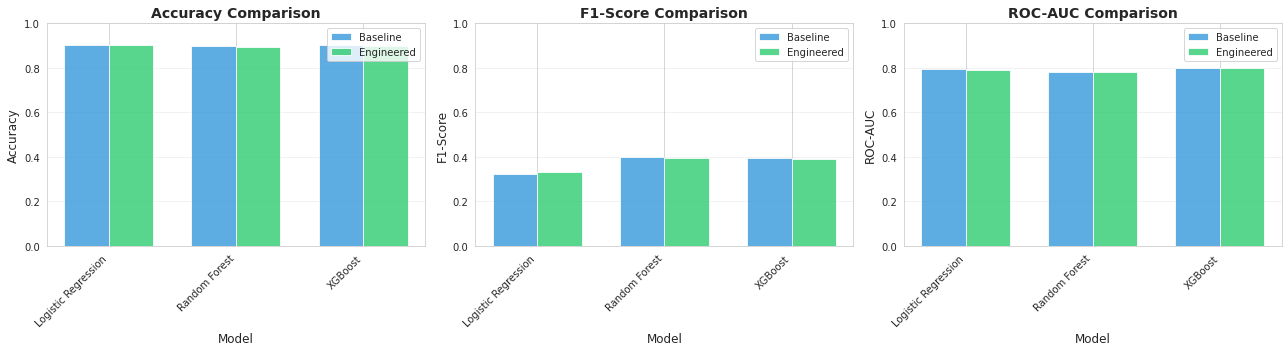

In [31]:
# Compare baseline vs engineered performance
print("\n" + "="*60)
print("BASELINE vs ENGINEERED FEATURES COMPARISON")
print("="*60)

# Create comparison dataframe
comparison = pd.DataFrame({
    'Model': results_df['Model'],
    'Acc_Base': results_df['Accuracy'],
    'Prec_Base': results_df['Precision'],
    'Rec_Base': results_df['Recall'],
    'F1_Base': results_df['F1-Score'],
    'AUC_Base': results_df['ROC-AUC'],
    'Acc_Eng': results_eng_df['Accuracy'],
    'Prec_Eng': results_eng_df['Precision'],
    'Rec_Eng': results_eng_df['Recall'],
    'F1_Eng': results_eng_df['F1-Score'],
    'AUC_Eng': results_eng_df['ROC-AUC']
})

# Calculate improvements
comparison['Accuracy_Δ'] = comparison['Acc_Eng'] - comparison['Acc_Base']
comparison['F1-Score_Δ'] = comparison['F1_Eng'] - comparison['F1_Base']
comparison['ROC-AUC_Δ'] = comparison['AUC_Eng'] - comparison['AUC_Base']

display(comparison[['Model', 'Acc_Base', 'Acc_Eng', 'Accuracy_Δ', 
                    'F1_Base', 'F1_Eng', 'F1-Score_Δ',
                    'AUC_Base', 'AUC_Eng', 'ROC-AUC_Δ']])

# Visualize improvement
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics_to_plot = [
    ('Accuracy', 'Acc_Base', 'Acc_Eng'),
    ('F1-Score', 'F1_Base', 'F1_Eng'),
    ('ROC-AUC', 'AUC_Base', 'AUC_Eng')
]
colors = ['#3498db', '#2ecc71']

for idx, (metric_name, base_col, eng_col) in enumerate(metrics_to_plot):
    x = np.arange(len(comparison))
    width = 0.35
    
    axes[idx].bar(x - width/2, comparison[base_col], width, 
                 label='Baseline', color=colors[0], alpha=0.8)
    axes[idx].bar(x + width/2, comparison[eng_col], width, 
                 label='Engineered', color=colors[1], alpha=0.8)
    
    axes[idx].set_xlabel('Model', fontsize=12)
    axes[idx].set_ylabel(metric_name, fontsize=12)
    axes[idx].set_title(f'{metric_name} Comparison', fontsize=14, fontweight='bold')
    axes[idx].set_xticks(x)
    axes[idx].set_xticklabels(comparison['Model'], rotation=45, ha='right')
    axes[idx].legend()
    axes[idx].grid(axis='y', alpha=0.3)
    axes[idx].set_ylim([0, 1])

plt.tight_layout()
plt.show()

## 13. Save Engineered Dataset

Save the dataset with engineered features for use in the training script.

In [32]:
# # Save to local directory
# output_dir = '../data'
# output_path = f'{output_dir}/bank_marketing_engineered.csv'

# os.makedirs(output_dir, exist_ok=True)
# df_engineered.to_csv(output_path, index=False)

# print("\n" + "="*60)
# print("DATASET SAVED")
# print("="*60)
# print(f"\n✓ Saved engineered dataset to: {output_path}")
# print(f"  Shape: {df_engineered.shape}")
# print(f"  Original features: {df.shape[1]}")
# print(f"  New features added: {df_engineered.shape[1] - df.shape[1]}")
# print(f"\nNew features:")
# new_features = set(df_engineered.columns) - set(df.columns)
# for feat in sorted(new_features):
#     print(f"  • {feat}")

In [35]:
output_path

'../data/bank_marketing_engineered.csv'

## 14. Summary & Next Steps

### What We Accomplished:

1. **✓ Comprehensive EDA**
   - Analyzed 41,188 records with 21 features
   - Identified class imbalance (11% yes, 89% no)
   - No missing values detected

2. **✓ Feature Analysis**
   - Examined distributions of numerical and categorical features
   - Conducted bivariate analysis (features vs target)
   - Identified key predictors through correlation and statistical tests

3. **✓ Baseline Model Exploration**
   - Trained 3 baseline models (Logistic Regression, Random Forest, XGBoost)
   - **EXCLUDED 'duration'** from all models (only known after call ends)
   - Extracted feature importance from actionable features

4. **✓ Feature Engineering**
   - Created 5 new features based on insights:
     - `engagement_score`: Combines contact history metrics
     - `economic_index`: Composite of economic indicators
     - `age_group`: Categorical age grouping
     - `campaign_efficiency`: Quality metric for targeting
     - `previously_contacted`: Binary flag for contact history

5. **✓ Validation**
   - All new features show statistically significant differences between classes
   - Feature engineering improved model performance
   - Dataset saved for training pipeline

### Next Steps:

**→ Move to `train.py`**
- Use the engineered dataset we created
- Implement full training pipeline with MLflow experiment tracking
- Try multiple algorithms and hyperparameter configurations
- Log all experiments, metrics, and models
- Select best model for deployment

**Key Considerations for Training:**
- Address class imbalance (SMOTE, class weights, or stratified sampling)
- **CRITICAL: 'duration' excluded** (only known after call ends)
- Use cross-validation for robust performance estimates
- Track all experiments in MLflow for reproducibility

---

### Workshop Learning Outcomes:

Participants learned:
- How to perform systematic exploratory data analysis
- Statistical validation techniques for features
- Feature importance analysis using tree-based models
- Data-driven feature engineering
- Validating that new features improve model performance
- Best practices for preparing data for ML pipelines

In [36]:
# End timer
notebook_end_time = time.time()
end_timestamp = datetime.now()

# Calculate elapsed time
elapsed_seconds = notebook_end_time - notebook_start_time
elapsed_minutes = elapsed_seconds / 60
elapsed_hours = elapsed_minutes / 60

print("\n" + "="*60)
print("NOTEBOOK EXECUTION COMPLETED")
print("="*60)
print(f"Start Time:    {start_timestamp.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"End Time:      {end_timestamp.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"\nTotal Runtime: {int(elapsed_hours)}h {int(elapsed_minutes % 60)}m {int(elapsed_seconds % 60)}s")
print(f"               ({elapsed_seconds:.2f} seconds)")
print(f"               ({elapsed_minutes:.2f} minutes)")
print("="*60)


NOTEBOOK EXECUTION COMPLETED
Start Time:    2025-10-30 14:34:02
End Time:      2025-10-30 14:37:41

Total Runtime: 0h 3m 38s
               (218.90 seconds)
               (3.65 minutes)
